## Workshop 3: The Pooling Problem

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [2]:
# Only run once at the start
!pip install -q pyomo
!pip install -q matplotlib

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
import pandas as pd
from ipywidgets import FloatSlider, interact
import platform

# Ipopt solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt"
        return "solver/ipopt"


solver_executable = setup_solver()

### 2. Pooling Milk for Blending and Distribution

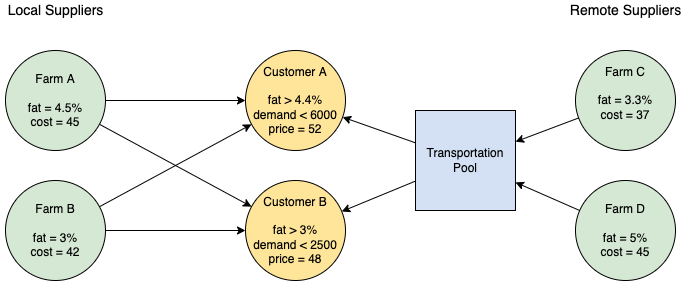

In [5]:
customers = pd.DataFrame({
    "Customer A": {"fat": 0.0445, "price": 52.0, "demand": 6000.0},
    "Customer B": {"fat": 0.030, "price": 48.0, "demand": 2500.0}
}).T

suppliers = pd.DataFrame({
    "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local"},
    "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local"},
    "Farm C": {"fat": 0.033, "cost": 37.0, "location": "remote"},
    "Farm D": {"fat": 0.050, "cost": 45.0, "location": "remote"}},
    ).T

local_suppliers = suppliers[suppliers["location"]=="local"]
remote_suppliers = suppliers[suppliers["location"]=="remote"]

print("\nCustomers")
print(customers)

print("\nLocal Suppliers")
print(local_suppliers)

print("\nRemote Suppliers")
print(remote_suppliers)


Customers
               fat  price  demand
Customer A  0.0445   52.0  6000.0
Customer B  0.0300   48.0  2500.0

Local Suppliers
          fat  cost location
Farm A  0.045  45.0    local
Farm B   0.03  42.0    local

Remote Suppliers
          fat  cost location
Farm C  0.033  37.0   remote
Farm D   0.05  45.0   remote


The milk distributor blends supplies from the two local farms to meet customer requirements. Let $L$ designate the set of local suppliers, and let $C$ designate the set of customers. The decision variable $x_{l,c}$ is the amount of milk from local supplier $l\in L$ mixed into the blend for customer $c\in C$.

The distributor’s objectives is to maximize profit:

\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) x_{l,c}
\end{align*}
 
where the notation $(l,c) \in L \times C$ indicates a summation over the cross-product of two sets. A useful interpretation is that $(l,c) \in L \times C$ describes all ways of delivering milk from $l$ to $c$. Each term ($\text{price}_{c} - \text{price}_{l}$) is then the profit earned by delivering one unit of milk from $l \in L$ to $c \in C$.

The amount of milk delivered to each customer can not exceed customer demand.

\begin{align*}
\sum_{l\in L} x_{l, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
 		
The milk blend delivered to each customer  must meet the minimum product quality requirement for milk fat. Assuming linear blending, the model becomes:

\begin{align*}
\sum_{(l,c)\ \in\ L \times C} \text{conc}_{l} x_{l,c} & \geq \text{conc}_{c} \sum_{l\in L} x_{l, c} & \forall c \in C
\end{align*}	

In [22]:
q = "fat"

model = ConcreteModel()

# define sources and customers
model.L = Set(initialize=local_suppliers.index)
model.C = Set(initialize=customers.index)
model.L2C = model.L * model.C

# set of quality components
model.Q = Set(initialize=["fat"])

# define local -> customer flowrates
model.x = Var(model.L * model.C, domain=NonNegativeReals)

@model.Objective(sense=maximize)
def profit(model):
    return sum(model.x[l, c]*(customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in model.L2C)

@model.Constraint(model.C)
def demand(model, c):
    return sum(model.x[l, c] for l in model.L) <= customers.loc[c, "demand"]

@model.Constraint(model.C)
def quality(model, c):
    return sum(model.x[l, c] * suppliers.loc[l, q] for l in model.L) >= sum(model.x[l, c] for l in model.L) * customers.loc[c, q]

SolverFactory('ipopt', executable=solver_executable).solve(model)

print(f"\nprofit = {model.profit():0.2f}\n")

X = pd.DataFrame([[l, c, round(model.x[l, c](), 1)] for l, c in model.L2C], columns = ["supplier", "customer", "blend"])
X = X.pivot_table(index="customer", columns="supplier")

X["fat"]  = sum(X.loc[:,('blend',l)] * suppliers.loc[l, "fat"] for l in model.L)/X.sum(axis=1)
X["Total"] = X.sum(axis=1)
print(X)


profit = 57600.00

             blend             fat      Total
supplier    Farm A  Farm B                   
customer                                     
Customer A  5800.0   200.0  0.0445  6000.0445
Customer B     0.0  2500.0  0.0300  2500.0300


In [7]:
# Create a Pyomo model
m = ConcreteModel()

# Define sets from dataframes (local_suppliers, remote_suppliers, customers, suppliers must be provided)
m.L = Set(initialize=local_suppliers.index)  # Local suppliers
m.R = Set(initialize=remote_suppliers.index)  # Remote suppliers
m.C = Set(initialize=customers.index)  # Customers

# Define decision variables
m.x = Var(m.L * m.C, domain=NonNegativeReals)  # Flowrates from local suppliers
m.y = Var(m.C, domain=NonNegativeReals)  # Flowrates from the pool
m.z = Var(m.R, domain=NonNegativeReals)  # Flowrates from remote suppliers
m.f = Var(bounds=(0.03, 0.051), domain=NonNegativeReals)  # Pool composition as a decision variable

# Objective function (maximize profit)
def profit_rule(m):
    return sum(m.x[l, c] * (customers.loc[c, "price"] - suppliers.loc[l, "cost"]) for l, c in m.L * m.C) \
         + sum(m.y[c] * customers.loc[c, "price"] for c in m.C) \
         - sum(m.z[r] * suppliers.loc[r, "cost"] for r in m.R)

m.profit = Objective(rule=profit_rule, sense=maximize)

# Customer demand constraint
def customer_demand_rule(m, c):
    return sum(m.x[l, c] for l in m.L) + m.y[c] <= customers.loc[c, "demand"]

m.customer_demand = Constraint(m.C, rule=customer_demand_rule)

# Pool balance constraint
def pool_balance_rule(m):
    return sum(m.z[r] for r in m.R) == sum(m.y[c] for c in m.C)

m.pool_balance = Constraint(rule=pool_balance_rule)

# Pool quality constraint (nonlinear)
def pool_quality_rule(m):
    return sum(suppliers.loc[r, "fat"] * m.z[r] for r in m.R) == m.f * sum(m.y[c] for c in m.C)

m.pool_quality = Constraint(rule=pool_quality_rule)

# Customer quality constraint (nonlinear)
def customer_quality_rule(m, c):
    return m.f * m.y[c] + sum(suppliers.loc[l, "fat"] * m.x[l, c] for l in m.L) \
         >= customers.loc[c, "fat"] * (sum(m.x[l, c] for l in m.L) + m.y[c])

m.customer_quality = Constraint(m.C, rule=customer_quality_rule)

# Solve using IPOPT solver
solver = SolverFactory('ipopt', executable=solver_executable)
results = solver.solve(m)

# Access the optimized profit
optimal_profit = value(m.profit)
print(f"Optimal Profit: {optimal_profit}")


Optimal Profit: 71500.00072166749
